In [35]:
import cirq
import numpy as np
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma, show_bloqs
from typing import *
import sympy
from qualtran import SoquetT
from qualtran.symbolics import SymbolicFloat, SymbolicInt
from qualtran.bloqs.basic_gates import CNOT, Hadamard, Rz, SGate, Ry, CZ, Rx, Swap
from qualtran.bloqs.rotations.phase_gradient import PhaseGradientUnitary
from qualtran.bloqs.qft import QFTTextBook
from qualtran.cirq_interop.t_complexity_protocol import t_complexity
from qualtran.resource_counting import BloqCount
import attrs

In [36]:
@attrs.frozen
class trial_state(Bloq): 
    N : int = 4 
    theta: float= 1
    phi: float = 1
    eps: SymbolicFloat = 1e-9

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.N)
        
    def build_composite_bloq(            
            self, bb: 'BloqBuilder', y: 'Soquet'
    ) -> Dict[str, 'Soquet']:

        eps = 1e-9 
        ys = bb.split(y)
       
        for i in range(self.N):
            ys[i] = bb.add(Ry(self.theta,eps),q=ys[i])

        ys[0], ys[3] = bb.add(CZ(), q1=ys[0], q2=ys[3])
        ys[1], ys[2] = bb.add(CZ(), q1=ys[1], q2=ys[2])

        ys[2] = bb.add(Ry(self.phi,eps),q=ys[2])
        ys[3] = bb.add(Ry(self.phi,eps),q=ys[3])

        ys[0], ys[3] = bb.add(CZ(), q1=ys[0], q2=ys[3])
        ys[1], ys[2] = bb.add(CZ(), q1=ys[1], q2=ys[2])
        
        y = bb.join(ys)
    
        return {'y': y}

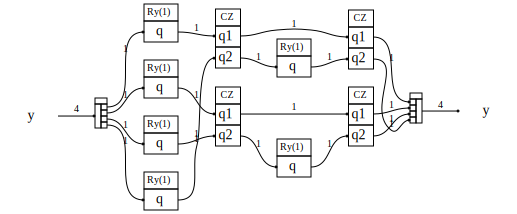

T-count:   0
Rotations: 6
Cliffords: 4



In [37]:
show_bloq(trial_state().decompose_bloq())
print(t_complexity(trial_state()))

In [38]:
@attrs.frozen
class symmetric_trial_state(Bloq): 
    N : int = 4 
    theta: float= 1
    phi: float = 1
    eps: SymbolicFloat = 1e-9

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.N)
        
    def build_composite_bloq(            
            self, bb: 'BloqBuilder', y: 'Soquet'
    ) -> Dict[str, 'Soquet']:

        eps = 1e-9 
        ys = bb.split(y)
       
        for i in range(self.N):
            ys[i] = bb.add(Ry(self.theta,eps),q=ys[i])

        ys[0], ys[3] = bb.add(CZ(), q1=ys[0], q2=ys[3])
        ys[1], ys[2] = bb.add(CZ(), q1=ys[1], q2=ys[2])

        for i in range(self.N):
            ys[i] = bb.add(Ry(self.phi/2,eps),q=ys[i])

        ys[0], ys[3] = bb.add(CZ(), q1=ys[0], q2=ys[3])
        ys[1], ys[2] = bb.add(CZ(), q1=ys[1], q2=ys[2])
        
        y = bb.join(ys)
    
        return {'y': y}

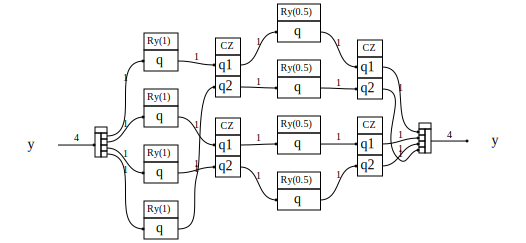

T-count:   0
Rotations: 8
Cliffords: 4



In [39]:
show_bloq(symmetric_trial_state().decompose_bloq())
print(t_complexity(symmetric_trial_state()))

In [40]:
@attrs.frozen
class first_implementation_circuit(Bloq): 
    N : int = 4 
    t: float= 1
    tau: float = 1
    U: float = 1
    eps: SymbolicFloat = 1e-9
    theta1: float = 4*t*tau
    theta2: float = tau*U/2

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.N)
        
    def build_composite_bloq(            
            self, bb: 'BloqBuilder', y: 'Soquet'
    ) -> Dict[str, 'Soquet']:

        ys = bb.split(y)
       
        ys[0], ys[2] = bb.add(CNOT(),ctrl=ys[0], target=ys[2])
        ys[0], ys[3] = bb.add(CNOT(),ctrl=ys[0], target=ys[3])

        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[1], target=ys[2])
        
        ys[2]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[2]) 
        ys[3]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[3]) 

        ys[0], ys[2] = bb.add(CNOT(),ctrl=ys[0], target=ys[2])
        ys[1], ys[3] = bb.add(CNOT(),ctrl=ys[1], target=ys[3])

        ys[2]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[2]) 
        ys[3]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[3]) 

        ys[2], ys[3] = bb.add(CNOT(),ctrl=ys[2], target=ys[3])

        ys[3]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[3]) 
        
        ys[0], ys[3] = bb.add(CNOT(),ctrl=ys[0], target=ys[3])
        ys[1], ys[3] = bb.add(CNOT(),ctrl=ys[1], target=ys[3])

        ys[3]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[3]) 
        
        ys[2], ys[3] = bb.add(CNOT(),ctrl=ys[2], target=ys[3])
        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[1], target=ys[2])

        for i in range(self.N):
            ys[i] = bb.add(Rx(self.theta1,self.eps),q=ys[i])


        
        y = bb.join(ys)
    
        return {'y': y}

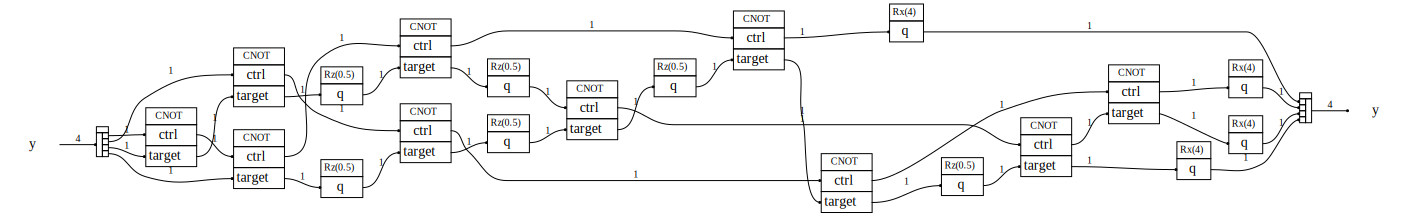

T-count:   0
Rotations: 10
Cliffords: 10



In [41]:
show_bloq(first_implementation_circuit().decompose_bloq())
print(t_complexity(first_implementation_circuit()))

In [50]:
@attrs.frozen
class second_implementation_circuit(Bloq): 
    N : int = 4 
    t: float= 1
    tau: float = 1
    U: float = 1
    eps: SymbolicFloat = 1e-9
    theta1: float = 4*t*tau
    theta2: float = tau*U/2

    @property
    def signature(self) -> Signature:
        return Signature.build(y=self.N)
        
    def build_composite_bloq(            
            self, bb: 'BloqBuilder', y: 'Soquet'
    ) -> Dict[str, 'Soquet']:

        ys = bb.split(y)

        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[2], target=ys[1])
        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[1], target=ys[0])

        ys[0] = bb.add(Rz(self.theta2, eps=self.eps),q=ys[0]) 
        ys[1]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[1]) 

        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[1], target=ys[0])
        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[2], target=ys[1])

        ys[0], ys[3] = bb.add(CNOT(),ctrl=ys[3], target=ys[0])
        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[0], target=ys[1])

        ys[0] = bb.add(Rz(self.theta2, eps=self.eps),q=ys[0]) 
        ys[1]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[1]) 

        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[0], target=ys[1])

        ys[0], ys[3] = bb.add(CNOT(),ctrl=ys[3], target=ys[0])   #check what's happening with the rectange highlighted by the paper
        ys[1], ys[2] = bb.add(Swap(1), x=ys[1], y=ys[2])

        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[1], target=ys[0])
        ys[0] = bb.add(Rz(self.theta2, eps=self.eps),q=ys[0]) 

        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[1], target=ys[0])
        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[2], target=ys[1])

        ys[0], ys[3] = bb.add(CNOT(),ctrl=ys[3], target=ys[0])
        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[0], target=ys[1])
        ys[1]= bb.add(Rz(self.theta2, eps=self.eps),q=ys[1]) 
        ys[0], ys[1] = bb.add(CNOT(),ctrl=ys[0], target=ys[1])
        ys[1], ys[2] = bb.add(CNOT(),ctrl=ys[2], target=ys[1])

        for i in range(self.N):
            ys[i] = bb.add(Rx(self.theta1,self.eps),q=ys[i])


        
        y = bb.join(ys)
    
        return {'y': y}

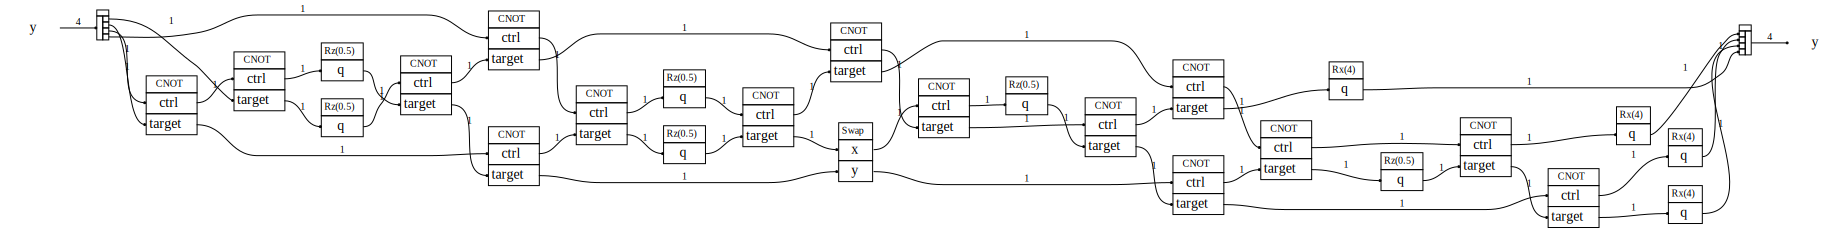

T-count:   0
Rotations: 10
Cliffords: 16



In [51]:
show_bloq(second_implementation_circuit().decompose_bloq())
print(t_complexity(second_implementation_circuit()))
